In [1]:
%cd ..

/app


In [43]:
import librosa
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from tonami import pitch_process as pp
from tonami import user
from tonami import Utterance as u
from tonami import Classifier as c

In [216]:
# Consts
filename = 'data/user_audio/testing/ex7_wo3_2022-03-03_193341.mp3'
# filename = 'data/user_audio/testing/ex7_wo3_2022-03-03_193430.mp3'
DB_THRESHOLD = 10
user_info = user.User(320, 100)
clf = c.Classifier(4)
clf.load_clf('tonami/data/pickled_svm_80.pkl')

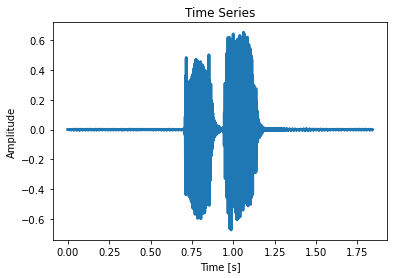

In [238]:
time_series, samplerate = librosa.load(filename)
time = np.arange(0, len(time_series)/samplerate, 1/samplerate)
plt.plot(time, time_series, linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Series')

plt.savefig('temp/time_series.png')

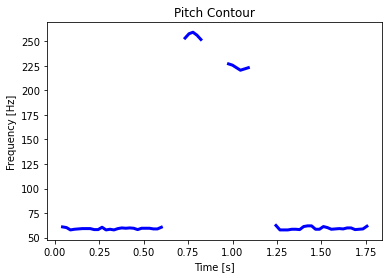

In [239]:
pitch_contour, _, _ = librosa.pyin(time_series, fmin=50, fmax=400)
time = np.arange(0, len(pitch_contour)/45, 1/45)
plt.plot(time, pitch_contour, color='blue', linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Pitch Contour')

plt.savefig('temp/pitch_counter.png')

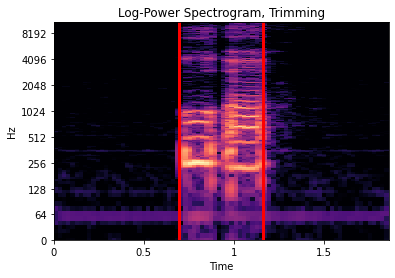

In [240]:
librosa.display.specshow(librosa.power_to_db(np.abs(librosa.stft(time_series))**2, ref=np.max),
                                 sr=samplerate, y_axis='log', x_axis='time')
plt.title("Log-Power Spectrogram, Trimming")
plt.axvline(x=15360/samplerate, color='red', linewidth=3)
plt.axvline(x=25600/samplerate, color='red', linewidth=3)

plt.savefig('temp/spectrogram.png')

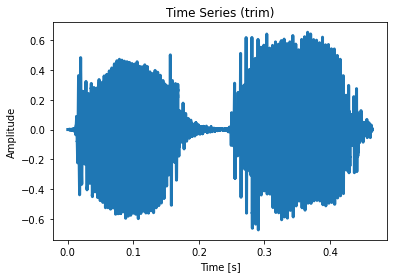

In [241]:
f_time_series, _ = librosa.effects.trim(y=time_series, top_db=DB_THRESHOLD)
time = np.arange(0, len(f_time_series)/samplerate, 1/samplerate)
plt.plot(time, f_time_series, linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Series (trim)')

plt.savefig('temp/time_series_trim.png')

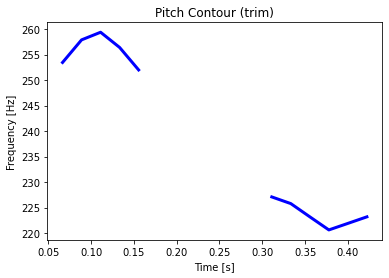

In [242]:
f_pitch_contour, _, _ = librosa.pyin(f_time_series, fmin=50, fmax=400)
time = np.arange(0, len(f_pitch_contour)/45, 1/45)
plt.plot(time, f_pitch_contour, color='blue', linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Pitch Contour (trim)')

plt.savefig('temp/pitch_contour_trim.png')

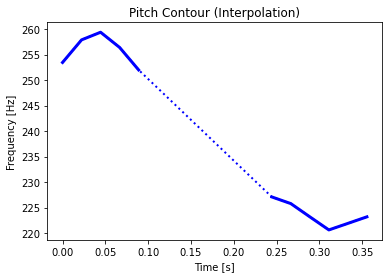

In [243]:
interp, user_nans = pp.preprocess(f_pitch_contour)
interp_np = np.array([interp], dtype=float)

interp_np = interp_np[0]
y_pitch = interp_np.copy()
y_interp = interp_np.copy()
y_pitch[user_nans] = np.nan

time = np.arange(0, len(interp_np)/45, 1/45)
plt.plot(time, y_interp, color='blue', linestyle=":", linewidth=2)
plt.plot(time, y_pitch, color='blue', linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Pitch Contour (Interpolation)')

plt.savefig('temp/pitch_contour_interpolation.png')

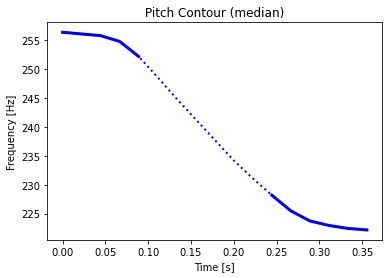

In [244]:
avgd = pp.moving_average(interp_np)

y_pitch = avgd.copy()
y_interp = avgd.copy()
y_pitch[user_nans] = np.nan

time = np.arange(0, len(interp_np)/45, 1/45)
plt.plot(time, y_interp, color='blue', linestyle=":", linewidth=2)
plt.plot(time, y_pitch, color='blue', linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Pitch Contour (median)')

plt.savefig('temp/pitch_contour_median.png')

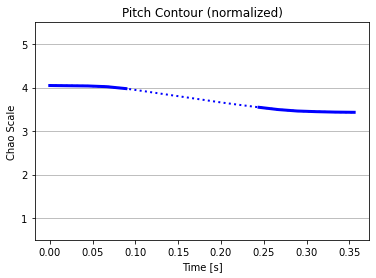

In [245]:
profile = user_info.get_pitch_profile()
normalized_pitch = pp.normalize_pitch(avgd, profile['max_f0'], profile['min_f0'])

y_pitch = normalized_pitch.copy()
y_interp = normalized_pitch.copy()
y_pitch[user_nans] = np.nan

time = np.arange(0, len(normalized_pitch)/45, 1/45)
plt.plot(time, y_interp, color='blue', linestyle=":", linewidth=2)
plt.plot(time, y_pitch, color='blue', linewidth=3)
plt.ylim(0.5,5.5)
plt.grid(axis='y')
plt.xlabel('Time [s]')
plt.ylabel('Chao Scale')
plt.title('Pitch Contour (normalized)')

plt.savefig('temp/pitch_contour_normalized.png')

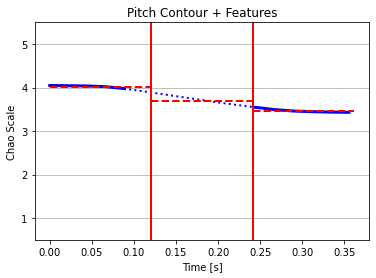

In [247]:
features = np.array([pp.basic_feat_calc(normalized_pitch)])

end = len(normalized_pitch)/47
x1, x2, x3 = [0, end/3], [end/3, end/3*2], [end/3*2, end]
y1, y2, y3 = [features[0][0], features[0][0]], [features[0][1], features[0][1]], [features[0][2], features[0][2]]
plt.plot(time, y_interp, color='blue', linestyle=":", linewidth=2)
plt.plot(time, y_pitch, color='blue', linewidth=3)
plt.plot(x1, y1, color='red', linestyle="--", linewidth=2)
plt.plot(x2, y2, color='red', linestyle="--", linewidth=2)
plt.plot(x3, y3, color='red', linestyle="--", linewidth=2)
plt.axvline(end/3, color='red', linewidth=2)
plt.axvline(end/3*2, color='red', linewidth=2)
plt.ylim(0.5, 5.5)
plt.grid(axis='y')
plt.xlabel('Time [s]')
plt.ylabel('Chao Scale')
plt.title('Pitch Contour + Features')

plt.savefig('temp/pitch_contour_features.png')

In [249]:
classified_tone, classified_prob = clf.classify_tones(features)
print(classified_prob[0])

[7.10089068e-03 4.43440297e-04 1.24560959e-02 9.79999573e-01]
